# Introduction
In this notebook we aim to simulate the orbital evolution of a planet in the presense of an additional force. We update accelerations which have been forced by arbitrary functions of $\dot{e}$ and $\dot{a}$. Equations used throughout this program are based on [Wolff, Dawson, & Murray-Clay (2012)](https://iopscience.iop.org/article/10.1088/0004-637X/746/2/171/pdf), hereafter referenced as WDMC. (See also Chapter 2 of Murray & Dermott.) For reference, a page of this paper's appendix containing the relevant equations is shown in a cell below. 

## Orbital Evolution: Python and REBOUND

In [188]:
%matplotlib inline
import rebound
import numpy as np
import matplotlib.pyplot as plt
import reboundx
from reboundx import constants
import math
Mj = 955e-6 #...Jupiter mass in Solar units
import datetime
from mpl_toolkits.mplot3d import Axes3D

To test the accuracy of the program, arbitrary functions are assigned to eccentricity and its evolution. Eccentricity is

$$ e(t) = A e_0 \left[\sin{\left(\frac{2\pi t}{\tau}\right)} + 1 \right]\ , $$

and the time-derivative is

$$ \dot{e} = \frac{2\pi A e_0}{\tau} \cos{\left(\frac{2\pi t}{\tau}\right)}\ ,$$

where $A$ is some constant

In [250]:
#...Initialize global parameters corresponding to HD 147018b
global e0, a0, Mp, Mstar, A, tau0, inc0
e0 = 0.5
a0 = 0.2
Mp = 0.002
Mstar = 1.0
tau0 = 1e0
A0 = 2.0
inc0 = np.radians(35.614629)

"A function for the theoretical expectation of the time-evolution of eccentricity."
def eFxn(init_e,time,tau,A):
    #e = A*init_e*(np.sin(2.0*np.pi*time/tau) + 1.0)
    e = init_e*np.sin(time)
    return e

def edotovereFxn(init_e,time,tau,A,e):
    #edot = (2.0*np.pi*A*init_e/tau)*np.cos(2.0*np.pi*time/tau)/e
    edot = init_e*np.cos(time)
    return edot


def setupSystem(e0=e0,a0=a0,Mp=Mp,Mstar=Mstar):
    sim = rebound.Simulation()
    sim.add(m=Mstar)
    sim.add(a=a0,e=e0,m=Mp,inc=inc0)#,omega=np.radians(66.0054),Omega=0.,M=np.radians(0.698350))
    #sim.move_to_com() # Moves to the center of momentum frame
    #sim.move_to_hel()
    return sim



In [247]:
force_is_velocity_dependent = True
def orbitalEvolution(reb_sim,rebx_effect,dt,timing):
    sim = reb_sim.contents
    t = sim.t #...time
    nyears = 2.0*np.pi
    
    #...Orbital parameters: REBOUND
    n = sim.particles[1].n #mean motion
    semi = sim.particles[1].a #semimajor axis
    e = sim.particles[1].e #eccentricity
    inc = sim.particles[1].inc #inclination 
    node = sim.particles[1].Omega #longitude of ascending node
    ω = sim.particles[1].omega #argument of pericenter
    pomega = sim.particles[1].pomega #longitude of pericenter
    f = sim.particles[1].f #true anomaly
    Manom = sim.particles[1].M #mean anomaly
    periq = semi*(1.0 - e) #perihelion distance (see mercury6_2.for)
    msum = sim.particles[0].m + sim.particles[1].m
    
    #...Position: REBOUND
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    d = sim.particles[1].d #...or see r below
    
    #...Velocity (Option 1): REBOUND
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz
    

    #...Setup eccentricity evolution
    edotovere = edotovereFxn(e0,t,tau0*nyears,A0,e)
    adotovera = 2.0*e**2.0*edotovere/(1.0 - e**2.0)
    idotoveri = 0.0

    if edotovere != 0.0:
        if e == 0.0:
            f = Manom
        else:
            temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2.0) - 1.0)/e
            temp = math.copysign(min(abs(temp),1.0),temp)
            f = math.acos(temp)
            if math.sin(Manom) < 0.0:
                f = 2.*np.pi - f
    
        #...Orbital equations WDMC (A5 - A8)
        #r = semi*(1.0-e**2.0)/(1.0+e*math.cos(f)) #...or sim.particles[1].d
        r = d
        rdot = math.sqrt(msum)*semi**(-1.0/2.0)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2.0)
        rfdot = math.sqrt(msum)*semi**(-1.0/2.0)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2)
        drde = -2.0*e*r/(1.0-e**2.0)-r**2.0*math.cos(f)/(semi*(1.0-e**2.0))
        drdotde = rdot/(e*(1.0-e**2.0))
        drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))
        peri = (pomega - node + 2.0*np.pi) % 2.0*np.pi
        
    #...Equations WDMC (A2); possibly to be moved inside/outside for-loop
    xdot = math.cos(node)*(rdot*math.cos(ω+f) - rfdot*math.sin(ω+f)) \
           - math.sin(node)*(rdot*math.cos(inc)*math.sin(ω+f) + rfdot*math.cos(inc)*math.cos(ω+f))
    ydot = math.sin(node)*(rdot*math.cos(ω+f) - rfdot*math.sin(ω+f)) \
           + math.cos(node)*(rdot*math.cos(inc)*math.sin(ω+f) + rfdot*math.cos(inc)*math.cos(ω+f))
    zdot = rdot*math.sin(inc)*math.sin(ω+f) + rfdot*math.sin(inc)*math.cos(ω+f)
    
    #...Velocity (Option 2): Orbital calculation
    #vx = xdot
    #vy = ydot
    #vz = zdot
    
    #...Update velocity: equations WDMC (A9 - A11)
    vux = x*adotovera 
    vuy = y*adotovera 
    vuz = z*adotovera 
    
    #...Update acceleration: equations WDMC (A12 - A14)
    ax = -vx*adotovera/2.0
    ay = -vy*adotovera/2.0
    az = -vz*adotovera/2.0

    if edotovere != 0.0 and e < 1.0 and e > 0.0:
        #...Update velocity: equations WDMC (A9 - A11)
        vux = vux + (r/semi - (1.0+e**2.0))*x*edotovere/(1.0-e**2.0)
        vuy = vuy + (r/semi - (1.0+e**2.0))*y*edotovere/(1.0-e**2.0)
        vuz = vuz + (r/semi - (1.0+e**2.0))*z*edotovere/(1.0-e**2.0)

        #...Update acceleration: equations WDMC (A12 - A14)
        ax = ax + (math.cos(node)*(drdotde*math.cos(ω+f) - drfdotde*math.sin(ω+f)) \
                - math.sin(node)*(drdotde*math.cos(inc)*math.sin(ω+f) \
                + drfdotde*math.cos(inc)*math.cos(ω+f)))*edotovere*e 
        ay = ay + (math.sin(node)*(drdotde*math.cos(ω+f) - drfdotde*math.sin(ω+f)) \
                + math.cos(node)*(drdotde*math.cos(inc)*math.sin(ω+f) \
                + drfdotde*math.cos(inc)*math.cos(ω+f)))*edotovere*e 
        az = az + (drdotde*math.sin(inc)*math.sin(ω+f) + drfdotde*math.sin(inc)*math.cos(ω+f))*edotovere*e

        sim.particles[1].ax += ax
        sim.particles[1].ay += ay
        sim.particles[1].az += az
        sim.particles[1].vx += vux
        sim.particles[1].vy += vuy
        sim.particles[1].vz += vuz

        
    else:
        sim.particles[1].ax += ax
        sim.particles[1].ay += ay
        sim.particles[1].az += az
        sim.particles[1].vx += vux
        sim.particles[1].vy += vuy
        sim.particles[1].vz += vuz    


In [256]:
#---INTEGRATION---#
def simIntegrate(sim,time_stop,Nout=100,addOrbitalEvolution=False):
    times = np.linspace(0.,time_stop*year,Nout)
    sim.dt = sim.particles[1].P/60.0 # small fraction of planetary period
    sim.integrator = "mercurius"
    e = np.zeros(Nout) 

    if addOrbitalEvolution == True: 
        rebx = reboundx.Extras(sim)
        custom_effect = rebx.add_custom_force(orbitalEvolution, force_is_velocity_dependent)
        
        for i,t in enumerate(times):
            sim.move_to_com()
            sim.integrate(t)
            e[i] = sim.particles[1].e
        times = times/(2.*np.pi)  
    return np.array([times,e])


t_stop = 1000
sim = setupSystem()
data = simIntegrate(sim,t_stop,addOrbitalEvolution=True)
times,e = data

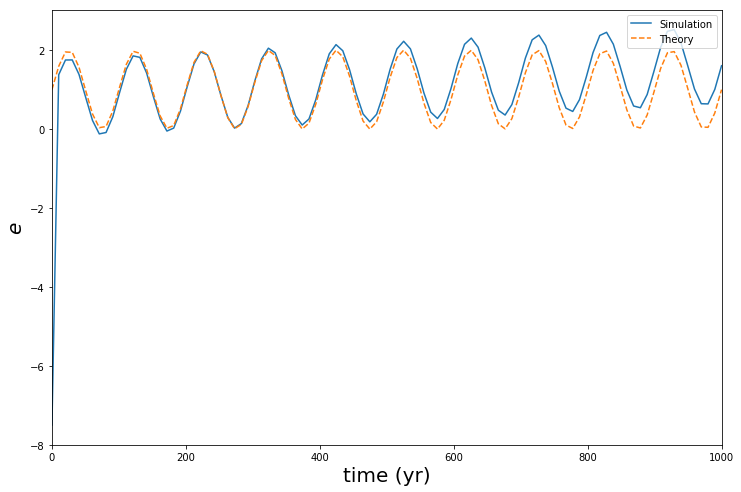

In [259]:
#---PLOTTING---#
eTheory = eFxn(e0,times,tau0,A0)
s=2
fig, ax1 = plt.subplots(1, 1, sharex=True,figsize=(6*s,4*s))
ax = plt.gca() 
ax.autoscale(enable=True, axis='x', tight=True)

ax1.plot(times,e-A0*4,label='Simulation')
ax1.set_ylabel(r'$e$ ',fontsize=20)
ax1.set_xlabel('time (yr)', fontsize=20)
ax1.plot(times,eTheory,'--',label='Theory')
#ax1.set_xlim(0,1000)
ax1.legend(loc="upper right");



#datestamp = str(datetime.datetime.now()).replace(" ","_")
#savetag = 'orbitalEvolution_'
#savetype = '.png'
#plt.savefig('plots/'+savetag+datestamp+savetype,dpi=100,bbox_inches='tight')

### Notes on code

- Velocities $\{\dot{x},\dot{y},\dot{z}\}$ may be retrieved by REBOUND via lines

    ```python
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz
    ```
    
    but for consistency they are explicitly calculated using equations WDMC (A2). Preliminary calculations show that the difference in velocities between the two methods of retrieval is approximately but not exactly equal to zero. In the end, the difference should not matter. 
    
    
- Equations WDMC (A5) are translated as

    ```python 
    rdot = n*semi/math.sqrt((1.0-e**2.0))*e*math.sin(f)
    rfdot = n*semi/math.sqrt((1.0-e**2.0))*(1.0+e*math.cos(f)) 
    ```
    
    But these forms resulted in `math domain error` messages in previous versions. Equivalent expressions 
    
    ```python
    rdot = math.sqrt(msum)*semi**(-1.0/2.0)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2.0)
    rfdot = math.sqrt(msum)*semi**(-1.0/2.0)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2)
    ```
    from `MFO_USER.FOR` have instead been adopted. Note that mean motion is
    
    $$n = \sqrt{\frac{G(M_{\star}+M)}{a^3}}\ .$$ 
    
    
- Definition of the argument of pericenter as

    ```python
    peri = (pomega - node + 2.0*np.pi) % 2.0*np.pi
    ```
    
    was a necessity imposed by `mercury6_2.for`. REBOUND may instead be used to retrieve 
    
    ```python
    sim.particles[1].omega
    ```
    
    but using `peri` also produces non-trivial, interesting results.
    
    

## Scratch space
The cell below serves as scratch space for modifications to code.

# Appendix from WDMC
![Image of Wolff et al. (2012) paper](WolffEquations.png)

# Understanding `mercury6_2.for`

The two subroutines in the Fortran program `mercury6_2.for` which concern us here are `MCO_X2EL.FOR` and `MFO_USER.FOR`. They contain equations sourced in Murray & Dermott (MD), who in chapter 2.8 write,

> We can now summarize an algorithm for transforming the position $(X,Y,Z)$ and velocity
$(\dot{X}, \dot{Y}, \dot{Z})$ of an object in an elliptical orbit in the standard reference
plane at a time $t$ to a set of six orbital elements, $a$, $e$, $I$, $\Omega$, $\omega$, and $f$,
and a time of pericenter passage, $\tau$.

Below is shown `MCO_X2EL.FOR` with additional in-line comments that reference equations from the text. 

```fortran
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
!      MCO_X2EL.FOR    (ErikSoft  23 January 2001)
!
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
! Author: John E. Chambers
!
! Calculates Keplerian orbital elements given relative coordinates and
! velocities, and GM = G times the sum of the masses.
!
! The elements are: q = perihelion distance
!                   e = eccentricity
!                   i = inclination
!                   p = longitude of perihelion (NOT argument of perihelion!!)
!                   n = longitude of ascending node
!                   l = mean anomaly (or mean longitude if e < 1.e-8)
!
!------------------------------------------------------------------------------
!
      subroutine mco_x2el (gm,x,y,z,u,v,w,q,e,i,p,n,l)
!
      implicit none
      include 'mercury.inc'
!
! Input/Output
      real*8 gm,q,e,i,p,n,l,x,y,z,u,v,w
!
! Local
      real*8 hx,hy,hz,h2,h,v2,r,rv,s,true
      real*8 ci,to,temp,tmp2,bige,f,cf,ce
!
!------------------------------------------------------------------------------
!
      hx = y * w  -  z * v ! MD (2.129)
      hy = z * u  -  x * w ! MD (2.129)
      hz = x * v  -  y * u ! MD (2.129)
      h2 = hx*hx + hy*hy + hz*hz ! MD (2.129)
      v2 = u * u  +  v * v  +  w * w ! MD (2.127)
      rv = x * u  +  y * v  +  z * w ! MD (2.128)
      r = sqrt(x*x + y*y + z*z) ! MD (2.126)
      h = sqrt(h2) ! MD (2.129)
      s = h2 / gm ! see MD (2.134) and (2.135)
!
! Inclination and node
      ci = hz / h ! MD (2.136)
      if (abs(ci).lt.1) then
        i = acos (ci) ! MD (2.136)
        n = atan2 (hx,-hy) ! MD (2.137)
        if (n.lt.0) n = n + TWOPI
      else
        if (ci.gt.0) i = 0.d0
        if (ci.lt.0) i = PI
        n = 0.d0
      end if
!
! Eccentricity and perihelion distance
      temp = 1.d0  +  s * (v2 / gm  -  2.d0 / r) ! MD (2.134) and (2.135)
      if (temp.le.0) then
        e = 0.d0
      else
        e = sqrt (temp) ! MD (2.134) and (2.135)
      end if
      q = s / (1.d0 + e) ! perihelion distance; see note below
!
! True longitude (aka θ; see MD chapter 2.3)
      if (hy.ne.0) then
        to = -hx/hy
        temp = (1.d0 - ci) * to
        tmp2 = to * to
        true = atan2((y*(1.d0+tmp2*ci)-x*temp),(x*(tmp2+ci)-y*temp))
      else
        true = atan2(y * ci, x)
      end if
      if (ci.lt.0) true = true + PI
!
      if (e.lt.3.d-8) then
        p = 0.d0
        l = true
      else
        ce = (v2*r - gm) / (e*gm)
!
! Mean anomaly for ellipse
        if (e.lt.1) then
          if (abs(ce).gt.1) ce = sign(1.d0,ce)
          bige = acos(ce)
          if (rv.lt.0) bige = TWOPI - bige
          l = bige - e*sin(bige)
        else
!
! Mean anomaly for hyperbola
          if (ce.lt.1) ce = 1.d0
          bige = log( ce + sqrt(ce*ce-1.d0) )
          if (rv.lt.0) bige = - bige
          l = e*sinh(bige) - bige
        end if
!
! Longitude of perihelion
        cf = (s - r) / (e*r)
        if (abs(cf).gt.1) cf = sign(1.d0,cf)
        f = acos(cf)
        if (rv.lt.0) f = TWOPI - f
        p = true - f
        p = mod (p + TWOPI + TWOPI, TWOPI)
      end if
!
      if (l.lt.0) l = l + TWOPI
      if (l.gt.TWOPI) l = mod (l, TWOPI)
!
!------------------------------------------------------------------------------
!
      return
      end
```

The explicit expression of semimajor axis is bypassed by expressing $a$ as a function of eccentricity. Perihelion distance is defined as $r_p = a(1-e).$ With algebra we can show that $a = \frac{s}{(1-e)(1+e)}$. Therefore, $q\equiv r_p = \frac{s}{1+e}$.

```fortran
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
!      MFO_USER.FOR    (ErikSoft   2 March 2001)
!
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
! Author: John E. Chambers
!
! Applies an arbitrary force, defined by the user.
!
! If using with the symplectic algorithm MAL_MVS, the force should be
! small compared with the force from the central object.
! If using with the conservative Bulirsch-Stoer algorithm MAL_BS2, the
! force should not be a function of the velocities.
!
! N.B. All coordinates and velocities must be with respect to central body
! ===
!------------------------------------------------------------------------------
!
      subroutine mfo_user (time,jcen,nbod,nbig,m,x,v,a,vu)
!
      implicit none
      include 'mercury.inc'
!
! Input/Output
      integer nbod, nbig
      real*8 time,jcen(3),m(nbod),x(3,nbod),v(3,nbod),a(3,nbod)
      real*8 vu(3,nbod)
!
! Local
      integer j
      real*8 peri, drde,drfdotde,drdotde,r, msum, rdot, rfdot
      real*8 periq, e, inc, pomega, node, Manom, f, temp, semi
      real*8 adotovera, edotovere,idotoveri,taugravz,taugrav
      real*8 cs,vrand,vkep

!
!------------------------------------------------------------------------------
      adotovera=0.d0
         do j = 1, nbod
            a(1,j) = 0.d0
            a(2,j) = 0.d0
            a(3,j) = 0.d0
            vu(1,j) = 0.d0
            vu(2,j) = 0.d0
            vu(3,j) = 0.d0
            if (j .gt. 1 .and. j .le. nbig) then
              msum = m(1) + m(j)
              call mco_x2el (msum,x(1,j),x(2,j),x(3,j),v(1,j),v(2,j),v(3,j),periq, e, inc, pomega, node, Manom)
              semi = periq/(1.d0-e)
              taugravz=0.29*semi**2.0*m(1)/m(j)
              taugrav=taugravz

              cs=1.29/semi**0.25
              vkep=29.8/semi**0.5
              vrand=vkep*(e**2.0+inc**2.0)**0.5
              if(vrand.ge.cs.and.abs(inc).lt.(cs/vkep)) then
                 taugrav=taugravz*(vrand/cs)**3.0                 
              end if
              if(abs(inc).gt.(cs/vkep)) then
                 taugrav=taugravz*(vrand/cs)**4.0                 
              end if

              edotovere=-1d0/(taugrav*365.25)
              idotoveri=2*edotovere

              if (edotovere.ne.0) then
                 if (e.eq.0) then
                    f = Manom
                 else
                    temp = (periq*(1.d0 + e)/(x(1,j)**2.d0+x(2,j)**2.d0+x(3,j)**2.d0)**(1.d0/2) - 1.d0) /e
                    temp = sign (min(abs(temp), 1.d0), temp)
                    f = acos(temp)
                    if (sin(Manom).lt.0) f = TWOPI - f
                 end if

                 r = semi * (1.d0-e**2.d0)/(1.d0+e*cos(f))
                 rdot = sqrt(msum)*semi**(-1.d0/2)*e*sin(f)*(1.d0-e**2.d0)**(-1.d0/2)
                 drdotde = rdot/(e*(1.d0-e**2.d0))
                 rfdot = sqrt(msum)*semi**(-1.d0/2)*(1.d0+e*cos(f))*(1.d0-e**2.d0)**(-1.d0/2)
                 drfdotde = rfdot*(e+cos(f))/((1.d0-e**2.d0)*(1.d0+e*cos(f)))
                 peri = mod(pomega - node + TWOPI, TWOPI)
                 drde = -2.d0*e*r/(1.d0-e**2.d0)-r**2.d0*cos(f)/(semi*(1.d0-e**2.d0))

              end if

               a(1,j) =  -(v(1,j)+3.d0*idotoveri*inc*x(3,j))/2.d0*adotovera
               a(2,j) =  -(v(2,j)-3.d0*idotoveri*inc*x(3,j))/2.d0*adotovera
               a(3,j) =  -(v(3,j)+3.d0*idotoveri*inc*x(3,j))/2.d0*adotovera
               vu(1,j) = x(1,j)*adotovera
               vu(2,j) = x(2,j)*adotovera
               vu(3,j) = x(3,j)*adotovera

               if (edotovere.ne.0.and.e.lt.1.and.e.gt.0) then
                    a(1,j) = a(1,j) + (cos(node)*(drdotde*cos(peri+f)-drfdotde*sin(peri+f)) &
                             - sin(node)*(drdotde*cos(inc)*sin(peri+f)+drfdotde*cos(inc)*cos(peri+f) &
                             -drde*x(3,j)/r*idotoveri*inc))*edotovere*e
                    a(2,j) = a(2,j)+ (sin(node)*(drdotde*cos(peri+f)-drfdotde*sin(peri+f)) &
                             + cos(node)*(drdotde*cos(inc)*sin(peri+f)+drfdotde*cos(inc)*cos(peri+f) &
                             -drde*x(3,j)/r*idotoveri*inc))*edotovere*e
                    a(3,j) = a(3,j) + (drdotde*sin(inc)*sin(peri+f)+drfdotde*sin(inc)*cos(peri+f) &
                             +drde*cos(inc)*sin(peri+f)*idotoveri*inc)*edotovere*e
                    vu(1,j) = vu(1,j) + (r/(semi*(1.d0-e**2))-(1.d0+e**2)/(1.d0-e**2))*x(1,j)*edotovere
                    vu(2,j) = vu(2,j) + (r/(semi*(1.d0-e**2))-(1.d0+e**2)/(1.d0-e**2))*x(2,j)*edotovere
                    vu(3,j) = vu(3,j) + (r/(semi*(1.d0-e**2))-(1.d0+e**2)/(1.d0-e**2))*x(3,j)*edotovere
               end if

               if (idotoveri.ne.0) then
                   a(1,j) = a(1,j) + sin(node)*(v(3,j)+x(3,j)*idotoveri)*idotoveri*inc
                   a(2,j) = a(2,j) +  - cos(node)*(v(3,j)+x(3,j)*idotoveri)*idotoveri*inc
                   a(3,j) = a(3,j)+((-sin(node)*v(1,j)+cos(node)*v(2,j)) &
                            +idotoveri*(-sin(node)*x(1,j)+cos(node)*x(2,j)))*idotoveri*inc
                   vu(1,j) = vu(1,j)+x(3,j)*sin(node)*inc*idotoveri
                   vu(2,j) = vu(2,j)-x(3,j)*cos(node)*inc*idotoveri
                   vu(3,j) = vu(3,j)+(-x(1,j)*sin(node)+x(2,j)*cos(node))*inc*idotoveri
               end if
            end if
         end do


```


## Notes on `MFO_USER.FOR` 

- Orbital evolution in this problem is constrained by 

    ```python
    idotoveri = 0.0  .
    ```
    
    Any terms containing `idotoveri` may be omitted in translation for efficiency and readability.
  


# References

Murray, C. D., & Dermott, S. F. 1999, Solar System Dynamics (Cambridge University Press, New York)

Wolff, S., Dawson, R. I., & Murray-Clay, R. A. 2012, ApJ, 746, 171